### td/tab/speedyqlearning – Tabular Speedy 𝑄-learning (programming)

In [2], the 𝑄-learning variant

𝑄𝑡+1(𝑠, 𝑎) ∶= 𝑄𝑡(𝑠, 𝑎) + 𝛼𝑡(ℬ𝑡𝑄𝑡−1(𝑠, 𝑎) − 𝑄𝑡(𝑠, 𝑎))+(1 − 𝛼𝑡)(ℬ𝑡𝑄𝑡(𝑠, 𝑎) − ℬ𝑡𝑄𝑡−1(𝑠, 𝑎)),

𝛼𝑡 ∶= 1/(𝑡 + 1),

ℬ𝑡𝑄𝑡(𝑠, 𝑎) ∶= 𝑅𝑡+1 + 𝛾 max_𝑎 𝑄𝑡(𝑆𝑡+1, 𝑎),

was defined and called Speedy 𝑄-learning. (Here ℬ𝑡 is the (usual) empirical Bellman operator. Note that it is applied to 𝑄𝑡 (𝑠, 𝑎) and to 𝑄𝑡−1(𝑠, 𝑎).) Implement Speedy 𝑄-learning for estimating 𝑞∗ and use it to estimate 𝜋∗ for cliff walking in Exercise gw/cliff.
Compare 𝑄-learning and Speedy 𝑄-learning with the learning rate
defined above and with adjusted learning rates. Which algorithms
converges faster? What is the influence of the learning rate?

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from random import choice, random, randint
from tqdm.notebook import tqdm

class GridCliff:
    
    def __init__(self, h, w):
        self.w = w
        self.h = h
        
        self.actions = [0, 1, 2, 3] #up, down, left, right
        
        self.start = h*w
        self.goal = (h+1)*w-1
        
        self.terminal = [self.goal]
        self.states = [s for s in range(h*w)] + [self.start, self.goal]
        self.cliff = [s for s in range(self.start+1, self.goal)]
        
        self.num_states = h*w + w
        self.num_actions = len(self.actions)
        
        #### state numbering ####
        # 0  1  2  3  4  5 
        # 6  7  8  9  10 11
        # 12 13 14 15 16 17
        # 18 #  #  #  #  23
        
        # 18 and 23 are the final states
        #### state numbering ####
        
    def state_coordinates(self, s):
        return (s // self.w, s % self.w)
        
    def step(self, s, a):
        assert s in (self.states + [self.start, self.goal]), f'{s=} not valid.'
        
        action_values = [-self.w, +self.w, -1, +1]
        sprime = s + action_values[a]
        
        if sprime in self.cliff:
            return self.start, -100
        elif (s // self.w) != (sprime // self.w) and a > 1: # out horizontally
            return s, -1
        elif sprime not in self.states: # out vertically
            return s, -1
        else:
            return sprime, -1

def epsilon_greedy_action(Q, s, ϵ):
    A = len(Q[s, :])
    
    if random() < ϵ:
        return randint(0, A-1)
    else:
        return Q[s, :].argmax()
    
def B(world, Q, s, a, γ):
    Sprime, R = world.step(s, a)
    return R + γ*Q[Sprime,:].max()

def q_learning(world, ϵ=0.1, α=0.1, γ=0.9, num_episodes=10, max_steps=100, lr_scheduler=True):
    
    # Initialize Q
    Q = np.random.random((world.num_states, world.num_actions))
    for t in world.terminal:
        Q[t] = 0
    for t in world.cliff:
        Q[t] = np.nan
    rewards = []
        
    # Loop through episodes
    for k in range(num_episodes):
        S = choice(world.states) # pick random state
        t = 0
        
        reward = 0
        for step in range(max_steps):
            if S in world.terminal: # if S terminal end episode
                break
    
            # Step with ϵ-greedy action
            A = epsilon_greedy_action(Q, S, ϵ)
            Sprime, R = world.step(S, A)
            Aprime = epsilon_greedy_action(Q, Sprime, ϵ)
            
            if lr_scheduler:
                αt = 1/(1 + t)
                t += 1
            else:
                αt = α
            
            # Update Q
            BQ = B(world, Q, S, A, γ)
            Q[S, A] = Q[S, A] + αt*(BQ - Q[S, A])
                        
            # Save current state and action
            S, A = Sprime, Aprime
            reward += R
            
        rewards.append(reward)
        
    return Q, rewards

def sq_learning(world, ϵ=0.1, α=0.1, γ=0.9, num_episodes=10, max_steps=100, lr_scheduler=True):

    # Initialize Q
    Q = np.random.random((world.num_states, world.num_actions))
    for t in world.terminal:
        Q[t] = 0
    for t in world.cliff:
        Q[t] = np.nan
    rewards = []

    # Loop through episodes    
    for k in range(num_episodes):
        S = choice(world.states) # pick random state
        t = 0

        reward = 0
        Q_old = Q.copy()
        for step in range(max_steps):
            if S in world.terminal: # if S terminal end episode
                break

            # Step with ϵ-greedy action
            A = epsilon_greedy_action(Q, S, ϵ)
            Sprime, R = world.step(S, A)
            
            if lr_scheduler:
                αt = 1/(1 + t)
                t += 1
            else:
                αt = α

            # Update Q
            BQ_t = B(world, Q, S, A, γ)
            BQ_old = B(world, Q_old, S, A, γ)

            Q_old[S, A] = Q[S, A].copy()
            Q[S, A] = Q[S, A] + αt*(BQ_old - Q[S, A]) + (1-αt)*(BQ_t - BQ_old)
            
            # Save current state
            S = Sprime
            reward += R
            
        rewards.append(reward)
        
    return Q, rewards

In [2]:
h, w = 5, 10

cliff = GridCliff(h, w)

In [3]:
def mse(Q):
    V_GT = np.zeros(h*w + w)
    for r in range(h+1):
        for c in range(w):
            if r == h :
                if c == 0:
                    V_GT[r*w + c] = -w -1
                else:
                    V_GT[r*w + c] = 0
            else:
                V_GT[r*w + c] = r + c - h - w + 1

    π_greedy = np.ones((cliff.num_states, cliff.num_actions))
    for s in cliff.states:
        π_greedy[s] = np.eye(cliff.num_actions)[Q[s, :].argmax()] 

    V = (π_greedy*Q).sum(axis=-1)
    for s in cliff.cliff:
        V[s] = 0.0
        
    return ((V - V_GT)**2).mean()

In [7]:
Q_out_sq, reward_sq = sq_learning(cliff, ϵ=0.1, α=1.0, γ=1.0, num_episodes=1000, max_steps=1000, lr_scheduler=True)
Q_out_q, reward_q = q_learning(cliff, ϵ=0.1, α=1.0, γ=1.0, num_episodes=1000, max_steps=1000, lr_scheduler=True)

print(f'Q-learning V-MSE:        {mse(Q_out_q)}')
print(f'Speedy Q-learning V-MSE: {mse(Q_out_sq)}')

Q-learning V-MSE:        0.038756165579280966
Speedy Q-learning V-MSE: 0.0018672322746179624


In [8]:
rewards_sq = []
rewards_q = []

for eps in tqdm(range(0, 5000, 100)):
    _, reward_sq = sq_learning(cliff, ϵ=0.1, α=1.0, γ=1.0, num_episodes=eps, max_steps=1000, lr_scheduler=True)
    _, reward_q = q_learning(cliff, ϵ=0.1, α=1.0, γ=1.0, num_episodes=eps, max_steps=1000, lr_scheduler=True)
    rewards_sq.append(reward_sq)
    rewards_q.append(reward_q)

  0%|          | 0/50 [00:00<?, ?it/s]

1/(t+1) schedule


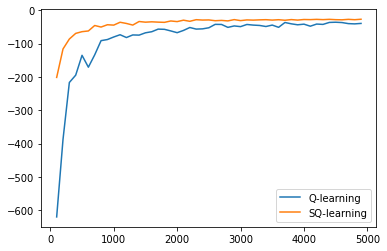

In [9]:
print('1/(t+1) schedule')
R_mean_q = [np.mean(r) for r in rewards_q]
R_mean_sq = [np.mean(r) for r in rewards_sq]
plt.plot([n for n in range(0, 5000, 100)], R_mean_q, label='Q-learning')
plt.plot([n for n in range(0, 5000, 100)], R_mean_sq, label='SQ-learning')
plt.legend()

In [12]:
rewards_sq = []
rewards_q = []

for alpha in tqdm(np.linspace(0.01, 1, 100)):
    _, reward_sq = sq_learning(cliff, ϵ=0.1, α=alpha, γ=1.0, num_episodes=5000, max_steps=5000, lr_scheduler=False)
    _, reward_q = q_learning(cliff, ϵ=0.1, α=alpha, γ=1.0, num_episodes=5000, max_steps=5000, lr_scheduler=False)
    rewards_sq.append(reward_sq)
    rewards_q.append(reward_q)

  0%|          | 0/100 [00:00<?, ?it/s]

Different learning rates


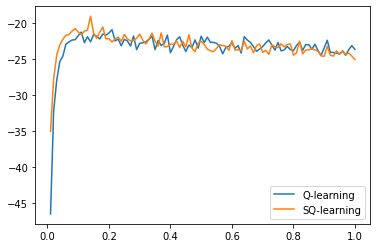

In [13]:
print('Different learning rates')
R_mean_q = [np.mean(r) for r in rewards_q]
R_mean_sq = [np.mean(r) for r in rewards_sq]
plt.plot(np.linspace(0.01, 1, 100), R_mean_q, label='Q-learning')
plt.plot(np.linspace(0.01, 1, 100), R_mean_sq, label='SQ-learning')
plt.legend()